In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

%matplotlib inline

# DengAI: Predicting Disease Spread 
## from DrivenData

After I've done two mini-projects on classification, I felt I was ready to do some regression.The goal of this challenge provided by [DrivenData](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/) is to predict the number of cases of dengue fever for two cities: San Juan and Iquitos. This fever is a mosquito-borne disease that occurs in tropical and subtropical parts of the world. The challenge seems perfect to learn about time series and, if I have enough time, domain adaptation. In Latin America, there is as many of nearly half billion cases per year.


<img align="left" src="San_Juan-Puerto_Rico.JPG" width="300" alt="Made with Angular" title="San Juan" hspace="100"/>
<img align="left" src="Iquitos-plaza.jpg" width="350" alt="Made with Bootstrap" title="Iquitos" hspace="100"/>




In [2]:
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d7781641.08369778!2d-69.47224494330946!3d17.76209125155511!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x8c03686fe268196f%3A0xad6b7f0f5c935adc!2sSan+Juan%2C+Puerto+Rico!5e0!3m2!1sen!2sca!4v1503409342798" width="600" height="450" frameborder="0" style="border:0" allowfullscreen></iframe>')

In [3]:
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d127400.42574378506!2d-73.35352759499273!3d-3.752745488607723!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x91ea10b0e440c1cb%3A0x9210b8d7040a6692!2sIquitos%2C+Peru!5e0!3m2!1sen!2sca!4v1503409426699" width="600" height="450" frameborder="0" style="border:0" allowfullscreen></iframe>')

In [4]:
!tree

.
├── benchmark.csv
├── benchmarks-master
│   ├── bees-benchmark.ipynb
│   ├── dengue-benchmark-statsmodels.ipynb
│   ├── fogwater-benchmark-model.ipynb
│   ├── LICENSE
│   └── README.md
├── benchmarks-master.zip
├── dengue_features_test.csv
├── dengue_features_train.csv
├── dengue_labels_train.csv
├── dengue-notebook.ipynb
├── dengue-notebook-Regressions-Copy1.ipynb
├── dengue-notebook-Regressions.ipynb
├── Iquitos-plaza.jpg
├── README.md
├── results.csv
├── results_lasso.csv
├── results_RandomForestRegression.csv
├── results_Ridge.csv
├── San_Juan-Puerto_Rico.JPG
└── submission_format.csv

1 directory, 21 files


# Data import

In [5]:
# load the provided data
train_features = pd.read_csv('dengue_features_train.csv')
train_labels = pd.read_csv('dengue_labels_train.csv')

# Seperate data for San Juan
sj_train_features = train_features.loc[train_features['city']=='sj']
sj_train_labels = train_labels.loc[train_labels['city']=='sj']

# Separate data for Iquitos
iq_train_features = train_features.loc[train_features['city'] == 'iq']
iq_train_labels = train_labels.loc[train_labels['city']=='iq']


print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

#features_submission = pd.read_csv("dengue_features_test.csv")

San Juan
features:  (936, 24)
labels  :  (936, 4)

Iquitos
features:  (520, 24)
labels  :  (520, 4)


## Data exploration

We will first start by looking at the features. We will see if there is some correlations between them that might be useful to use later. Then, we will merge the label with the features to explore the distribution of the case with respect to time. 

In [6]:
sj_train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


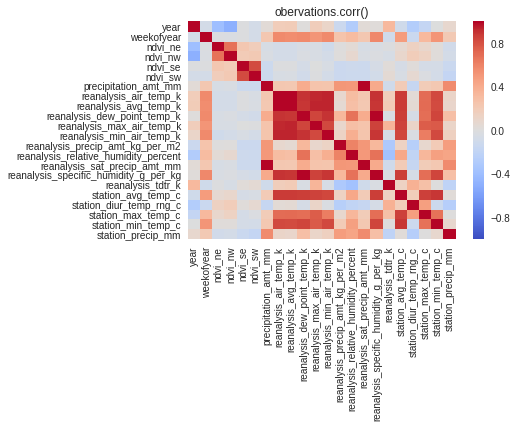

In [7]:
sns.heatmap(sj_train_features.corr(),cmap='coolwarm')
plt.title('obervations.corr()')

In [8]:
# Null check
pd.isnull(sj_train_features).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_t

In [9]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

/home/louis/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


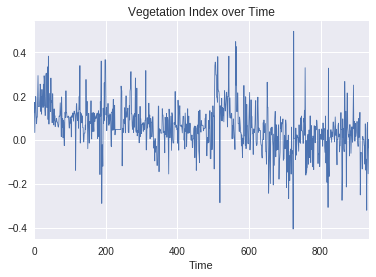

In [10]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [11]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  1998.82692308
var : 27.1657342657

Iquitos
mean:  2005.0
var : 8.51637764933


We now look at the distribution of total cases.

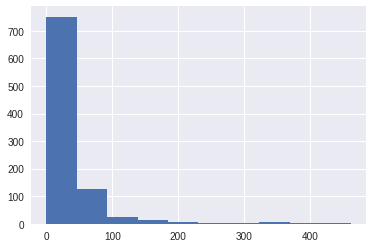

In [12]:
sj_train_labels.total_cases.hist()

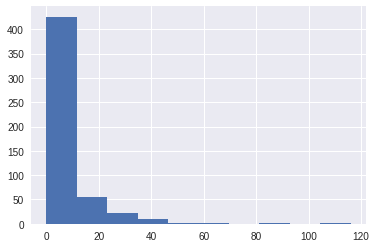

In [13]:
iq_train_labels.total_cases.hist()

In [14]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

/home/louis/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/louis/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


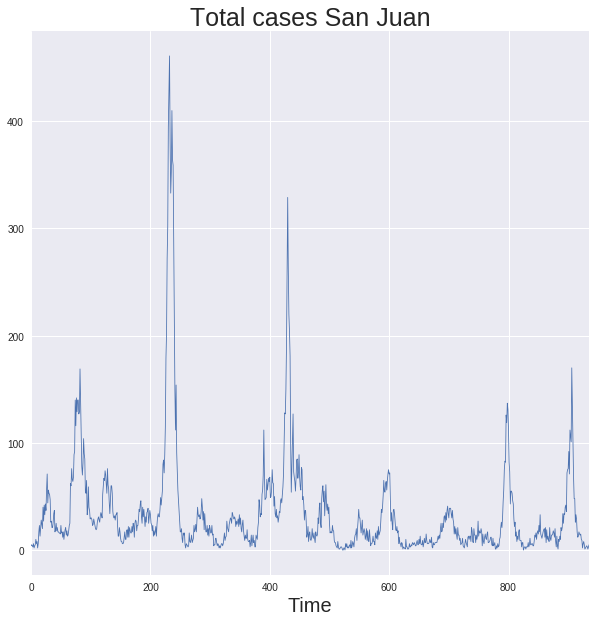

In [15]:
plt.figure(figsize=(10,10))
(sj_train_features
     .total_cases
     .plot
     .line(lw=0.8))
plt.title('Total cases San Juan', fontsize = 25)
plt.xlabel('Time',fontsize = 20)

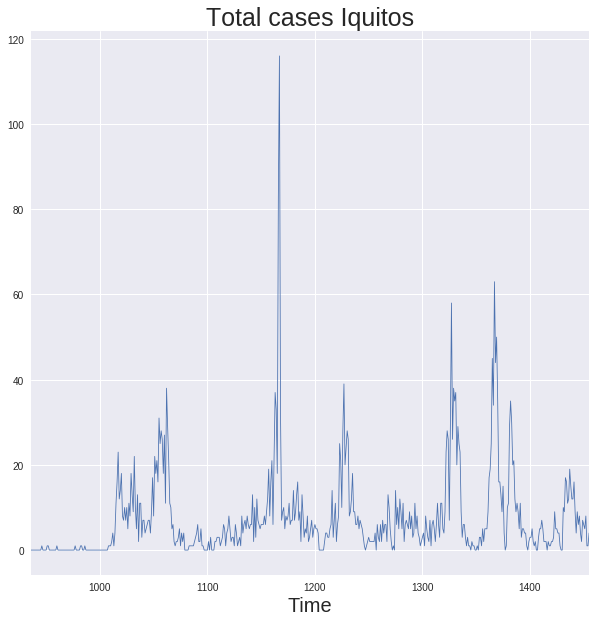

In [16]:
plt.figure(figsize=(10,10))
(iq_train_features
     .total_cases
     .plot
     .line(lw=0.8))

plt.title('Total cases Iquitos', fontsize=25)
plt.xlabel('Time', fontsize=20)

In [17]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

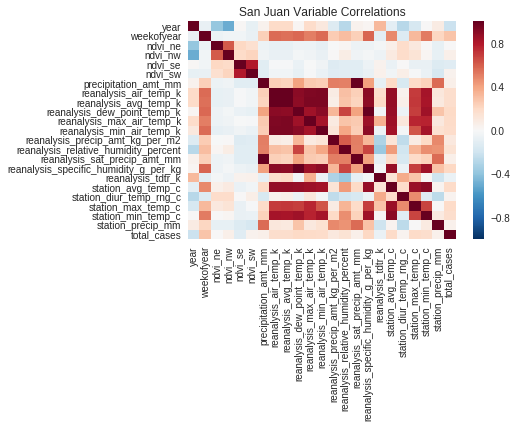

In [18]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

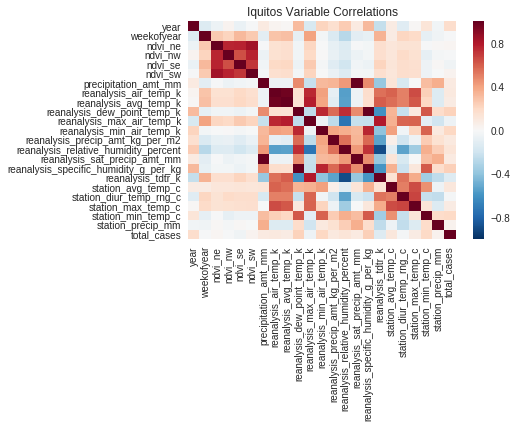

In [19]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

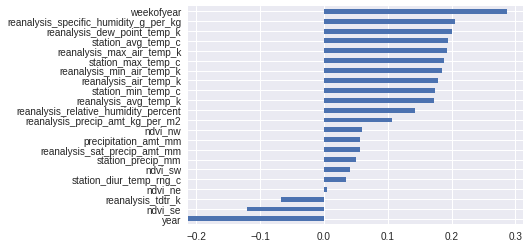

In [20]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values()
     .plot
     .barh())

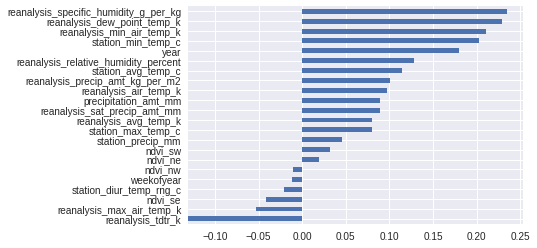

In [21]:
# San Juan
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values()
     .plot
     .barh())

## Preprocessing of the data

In [22]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [23]:
sj_train, iq_train = preprocess_data('dengue_features_train.csv',
                                    labels_path="dengue_labels_train.csv")

In [24]:
sj_train.describe()


,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [25]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


## Training 

In [26]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [27]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm


def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.0808823529
best alpha =  1e-08
best score =  6.46666666667


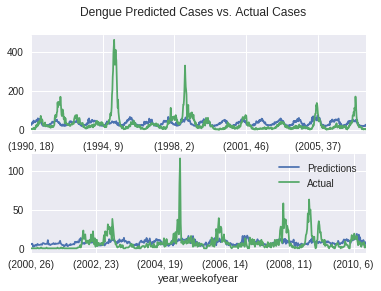

In [28]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [29]:
sj_test, iq_test = preprocess_data('dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")